In [181]:
import implementations_sk
import numpy as np
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
import branca.colormap as cm
import math
import folium
%matplotlib inline

In [139]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [140]:
from importlib import reload
reload(implementations_sk)
from implementations_sk import *

**Questions to Answer**

**1.** Which are the most cited patents (by other US patents), within the field of AI?

**2.** How much AI related patents granted through years and what its the percentage? 

**3.** We know that from common knowledge AI related researches increased and decreased agin in past decades, can we observe this situation by analysing the number of patents through years (in 1900s)? We also know that AI is one of the most popular area of research nowadays, will these popularity will also fade away like it has on the past or this time the characteristic of the popularity trend is different? 

**4.** Which countries have the most patents related to artificial intelligence? 

**5.** Who are the most prolific inventors?

**6.** Which companies are holding most AI patents? Is there a relationship between number of AI patents hold and the rank (according to Forbes top 500) of a company (meaning that smartest companies are also the the biggest ones)? 

**7.** Considering that Putin recently said “the nation that leads in AI will be the ruler of the world”. What is the relationship between number AI related patents and the rank of countries’ defense industry?

First, we gathered all the patents related to AI.

Keywords related to Artificla Intelligence has been gathered from different sources into "ai_keywords.txt".

In [141]:
keywords = set()

f = open("data/ai_keywords.txt")
for line in f.readlines():
    keywords.add(line.strip('\n'))

Initialize two dictionaries, one for counting the total number of patent granted and one for keeping track of AI related patents.

In [142]:
num_patents_by_year = dict()
ai_patents_by_year = dict()
for i in range(2018-1976):
    num_patents_by_year[str(1976+i)] = int()
    ai_patents_by_year[str(1976+i)] = pd.DataFrame()
    
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12",]

We iterate through years and months to get total number of patents.

In [143]:
pickle_in = open("data/num_patents_by_year.pickle","rb")
num_patents_by_year = pickle.load(pickle_in)

IPC code "G06" corresponds to "Computing; Calculating; Counting". More information related to IPC can be found [here](http://www.wipo.int/classifications/ipc/en/).

In [144]:
ipc_list = [("G", "06", "-")]

We iterate through years and months to get total number of patents related to AI.

In [145]:
pickle_in = open("data/ai_patents_by_year.pickle","rb")
ai_patents_by_year = pickle.load(pickle_in)

It seem that for 2015, something went wrong and no patent has been granted under IPC category "G06". (We checked and the error were not caused by our code.) Note that error caused by the PatensView itself.

We wanted to start with a basic question.

**1.** Which are the most cited patents (by other US patents) within the field of AI?

To answer this questions, we first, gathered all the patents in a single DataFrame.

In [146]:
all_ai_patents = pd.DataFrame()
for year in ai_patents_by_year:
    all_ai_patents = pd.concat([all_ai_patents, ai_patents_by_year[year]], ignore_index=True)

We organized the DataFrame to be able to see country, organiaztion, inventors and date more clearly.

Since different inventors could carry the same name, we are going to use their unique IDs to differentiate them.

In [147]:
inventor_id_name = dict()
for row in all_ai_patents["inventors"]:
    inventor_id = row[0]["inventor_id"]
    inventor_name = str(row[0]["inventor_first_name"]) + " " + str(row[0]["inventor_last_name"])
    inventor_id_name[inventor_id] = inventor_name

In [148]:
all_ai_patents = all_ai_patents.rename(columns={'patent_num_cited_by_us_patents': 'cited_by_count',}) 

all_ai_patents["country"] = all_ai_patents["assignees"].apply(lambda row: row[0]["assignee_country"])
all_ai_patents["organization"] = all_ai_patents["assignees"].apply(lambda row: row[0]["assignee_organization"])
all_ai_patents["inventor_id"] = all_ai_patents["inventors"].apply(lambda row: row[0]["inventor_id"])
all_ai_patents["inventor_name"] = all_ai_patents["inventor_id"].apply(lambda row: inventor_id_name[row])
all_ai_patents["year"] = all_ai_patents["patent_date"].apply(lambda row: int(row.split("-")[0]))
all_ai_patents["month"] = all_ai_patents["patent_date"].apply(lambda row: int(row.split("-")[1]))

all_ai_patents["cited_by_count"] = all_ai_patents["cited_by_count"].astype("int64")

all_ai_patents.index = all_ai_patents.patent_number
all_ai_patents = all_ai_patents.drop(columns=['assignees', 'inventors', 'patent_date', 'patent_number'])

In [149]:
all_ai_patents.head(5)

,patent_title,cited_by_count,country,organization,inventor_id,inventor_name,year,month
patent_number,,,,,,,,
3935562,Pattern recognition method and apparatus,14,None,None,3932839-1,Richard G. Stephens,1976,1
3936800,Pattern recognition system,95,None,None,3936800-1,Masakazu Ejiri,1976,2
3938089,Double read system for character recognition s...,15,US,Burroughs Corporation,3938089-1,Arvin D. McGregor,1976,2
3942153,Document transport and scanning system for opt...,3,US,Recognition Equipment Incorporated,3942153-1,Jack E. Balko,1976,3
3942169,Pattern recognition system,10,None,None,3942169-1,Yoshiji Fujimoto,1976,3


In our initial analysis we observe that, the patent dataset has a field for number of times that a particular patent cited by other patents however, further anaylsis showed that this field based only on US patentes. More clearly, here is the description of this field: "Number of times the patent was cited by other US patents". Consequently, we don't have information about citations from other countries and therefore, decided to restrict the question into citation made only by US patents.

Note that actual patents are not only from US, just the number of citation that a particular patent have is calculated only by citation of other US patents.

In [150]:
top_patents = all_ai_patents.sort_values(by='cited_by_count', ascending=False)
top_patents = top_patents[["patent_title","cited_by_count", "year", "organization",\
                           "inventor_name", "country"]]


with pd.option_context('display.max_colwidth', -1):
    display(top_patents.head(20))

,patent_title,cited_by_count,year,organization,inventor_name,country
patent_number,,,,,,
5875108,Ergonomic man-machine interface incorporating adaptive pattern recognition based control system,849,1999,None,Steven M. Hoffberg,None
5867799,Information system and method for filtering a massive flow of information entities to meet user information classification needs,736,1999,None,Andrew K. Lang,None
5933822,Apparatus and methods for an information retrieval system that employs natural language processing of search results to improve overall precision,599,1999,Microsoft Corporation,Lisa C. Braden-Harder,US
6055573,Communicating with a computer based on an updated purchase behavior classification of a particular consumer,598,2000,"SuperMarkets Online, Inc.",Will H. Gardenswartz,US
5974396,Method and system for gathering and analyzing consumer purchasing information based on product and consumer clustering relationships,597,1999,"Moore Business Forms, Inc.",Michael W. Anderson,US
6157955,Packet processing system including a policy engine having a classification unit,542,2000,Intel Corporation,Pradip Shankar,US
6363160,Interface using pattern recognition and tracking,456,2002,Intel Corporation,Boon-Lock Yeo,US
4843562,Broadcast information classification system and method,442,1989,Broadcast Data Systems Limited Partnership,Stephen C. Kenyon,US
6330546,Risk determination and management using predictive modeling and transaction profiles for individual transacting entities,430,2001,"HNC Software, Inc.",Allen P. Jost,US


Looking at the names of top cited patents, they potentially, have a lots of area of use. Take for example, *"Predictive modeling of consumer financial behavior"* patent, this technology is clearly, highly beneficial for any kind of company that interests in financial behaviour of its consumers (which is pretty much any company). Therefore, the use and popularity of this patent is quite expected as many other top-cited patens.

It is expected that most cited patents should be granted much earlier and this is the case for most of the top-cited patents including top 3 (all granted in 1999) however we also observe that there are some patents that are relatively new (e.g. 2002, 2011). This might be an indication of that innovations in this area still continues and there are many researches and technologies that are based on these patents.

Apart from citations by US patents, we don't have information about number of citations that a patent get by other patents. This means that we don't have a global picture of patent citations and for this reason, we decided restrict this part of our study to only analyzing top cited patents (as we did above) and not further. Since our study is not country specific and analyzing top cited data we have (top cited patents by other US patents) would only be related to US, we though that it is not completely aligns with the purpose our study. 

Now, we move onto deeper analysis of AI related patents.

**2.** How much AI related patents granted through years? 

**3.** We know that from common knowledge AI related researches increased and decreased again in past decades, can we observe this situation by analysing the number of patents through years (in 1900s)? We also know that AI is one of the most popular area of research nowadays, will these popularity will also fade away like it has on the past or this time the characteristic of the popularity trend is different? 

First, we calculated the number of overall and AI patents granted on each year.

In [151]:
ai_num_patents_by_year_df = pd.DataFrame(columns=['year','number_of_ai_patents'])
num_patents_by_year_df = pd.DataFrame(columns=['year','number_of_patents'])
for year in ai_patents_by_year:
    ai_num_patents_by_year_df = ai_num_patents_by_year_df\
        .append({'year': year,'number_of_ai_patents': len(ai_patents_by_year[year])}, ignore_index=True)
    num_patents_by_year_df = num_patents_by_year_df\
        .append({'year': year,'number_of_patents': num_patents_by_year[year]}, ignore_index=True)

Since there were something wrong with the year 2005, we were not able to use data belongs to that year and, data for the year 2017 still is not complete. We decided to drop these two years from dataset in order to maintain the continuity of line graphs. We though that dropping them is right course of action both for representation and analysis of the data.

In [152]:
ai_num_patents_by_year_df = ai_num_patents_by_year_df[~ai_num_patents_by_year_df.year.isin(["2005","2017"])]
num_patents_by_year_df = num_patents_by_year_df[~num_patents_by_year_df.year.isin(["2005","2017"])]

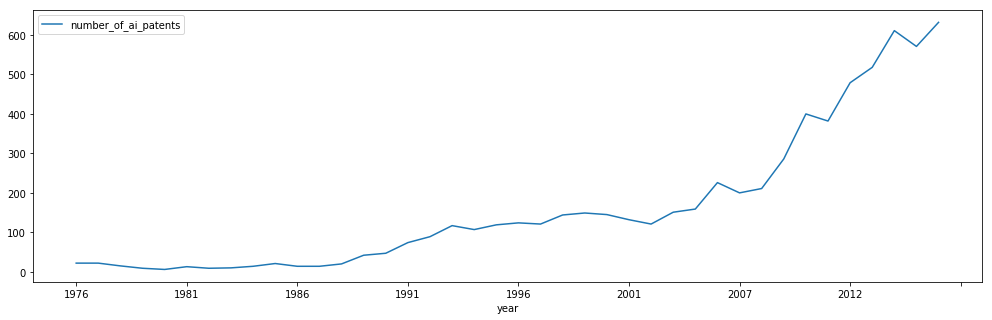

In [153]:
ai_num_patents_by_year_df.plot(x="year", y="number_of_ai_patents", figsize=(17,5),)

From this figure, it seems that there are two periods of time when number of AI patent rised which are 1986-1996 and 2006-2016. Other than these, the amount of patent seems pretty steady.  But since overall number of patents also rising over years, to be able to see the whole picture and make a more complete analysis, we also need to check the percentage of AI patents over all patents through years. 

In [154]:
merged_num_patent = pd.merge(ai_num_patents_by_year_df, num_patents_by_year_df, on="year")

merged_num_patent['ai_precentage'] =\
    merged_num_patent['number_of_ai_patents'] / merged_num_patent['number_of_patents'] * 100

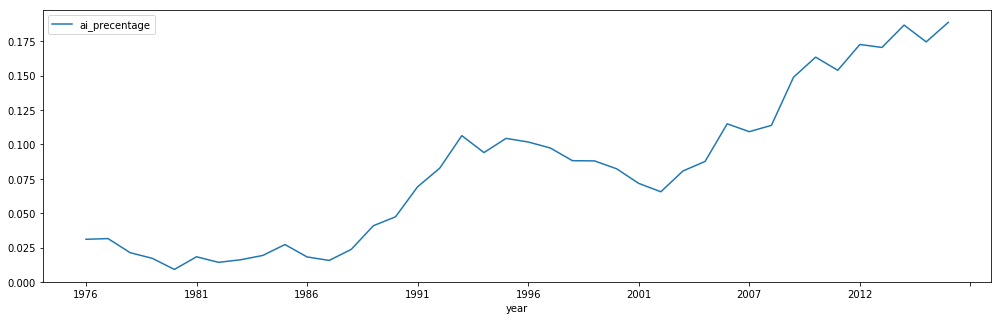

In [155]:
merged_num_patent.plot(x="year", y="ai_precentage", figsize=(17,5),)

There are couple of observations worth mentioning about these figures. **First** of all,  the graph starts with a decline from 1976. We already know that AI was popular field of research at 1960s (e.g. Artificial Neural Networks invented in this period.) and started to decline after that (mostly because of the lack of processing power and data). Although, we don't have data of 1960s, we can see that the graph starts with a steady line in 1976 then, rapid decline starting from 1977. It continues to decline for 3 years until it has the lowest value in 1980. The rate in 1977 is only reached again in 1989 which is 12 years lates.  So,we can derive that the line-graph's confirms our knowledge about the popularity of AI researches in 1960s. At this point, we though that it is also safe to think that percentage of AI patents is an indication the popularity of AI researches among others. **Another** interesting point is that percentage of AI patents rapidly rised from 1987 until 1994 then, stayed steady about 3 years and started to decline again. It continue to decline for 5 years, until 2002. Again, the rate of AI patents in 1997 is only reached after 10 years, around 2007. We can see that this trend is pretty similar to 1960s', it starts with a rapid increase, followed by a steady period then, a decrease for couple of years and in both situation, 13 years had to past before the rate come back to where it was. With the help of these trends, we can try to analyze the ***current situation***. We see that there is a dramatic increase on patent rates from 2002 to 2012 then, it stayed about the same rate with fluctuations. The characteristic that increasing rapidly and entering into steady phase is pretty similar to what we observed in last decades however it seems that the steady phase won't followed by a decline since the rates started to increase again in 2016. Although this might be an indication that popularity of AI related researches won't decline this time, like it did before, we still think that it is too early to infer that. The first two phases were similar to what has been observed in the past trends and it requires time (at least couple more years) to decide whether this time will be different or not.

It is clear that the AI researches are dramatically increased over 40 years, it was around 30 per/year with 0.03 percentage overall patents and It is around 700 per/year with a percentage of 0.12 now.

Further analysis related to characterictics of these trends (e.g. which types of companies involved, who are the invertors, which countries lead these trends etc.) will be examined later in this study.

**4.** Which countries have the most patents related to artificial intelligence? 

We create a dictionary to keep track of how mucn AI patents each country has through years.

In [156]:
ai_patent_by_country = dict()
for country in all_ai_patents.country.unique():
    ai_patent_by_country[country] = dict()
    for i in range(2018-1976):
        ai_patent_by_country[country][1976+i] = int()

for country, year in zip(all_ai_patents["country"], all_ai_patents["year"]):
    ai_patent_by_country[country][year] += 1

del ai_patent_by_country[None]
del ai_patent_by_country["City of\""]

We created a Dataframe with a row for each country and a column for each year.

In [157]:
country_year_df =\
pd.DataFrame([(country,year,value) for country,v in ai_patent_by_country.items() for year,value in v.items()],\
             columns = ['country','year','patent_num'])
country_year_df = country_year_df.pivot(index='country', columns='year', values='patent_num')

In [158]:
country_year_df.head(5)

year,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
country,,,,,,,,,,,,,,,,,,,,,
AE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
AU,0,0,0,0,0,0,0,0,0,0,...,0,0,1,3,1,4,2,1,2,0
BB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
BE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,1,1,0


We though that stacked bar chart would be a good indication of both to see which countries hold the most AI patents and observe change in number of AI patent through years.

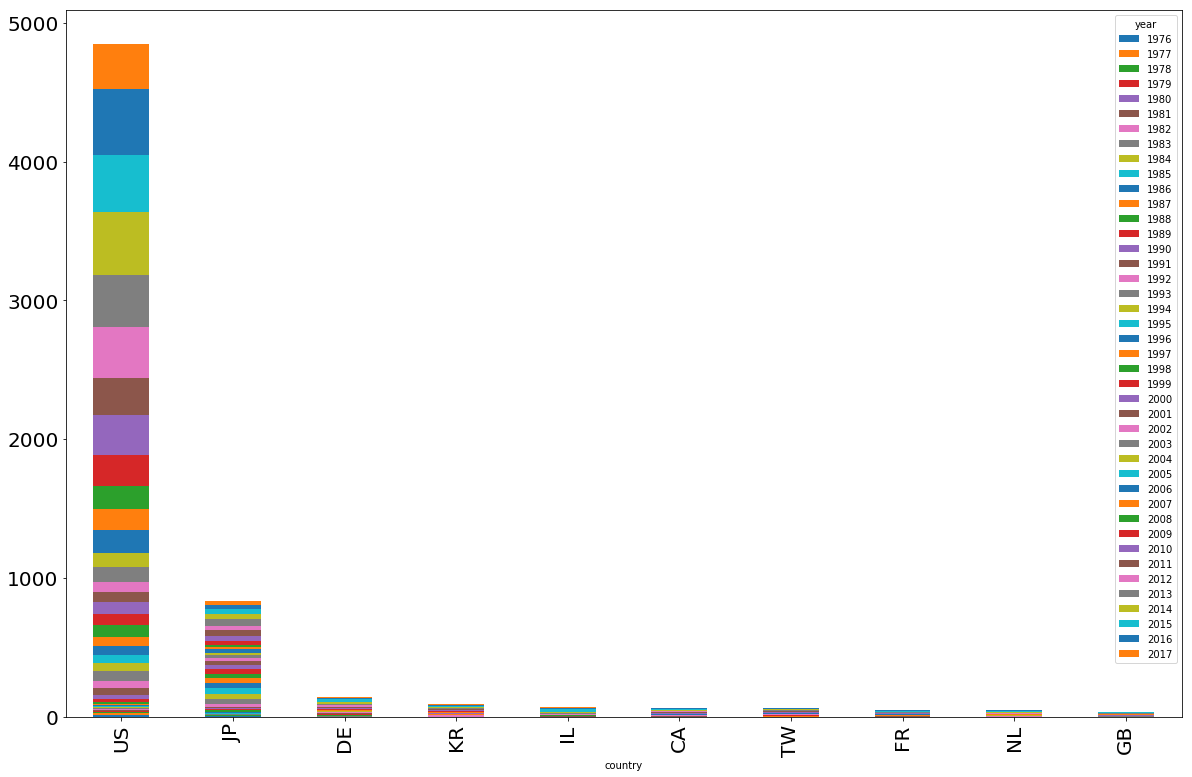

In [160]:
country_year_df_copy = country_year_df.copy()
country_year_df_copy['total'] = country_year_df_copy.apply(sum, axis=1)
clean_df = country_year_df_copy.sort_values(by='total', ascending=False).drop('total',axis=1).head(10)
clean_df.plot.bar(stacked=True, fontsize=20, figsize=(20,13));

**[Interpretation of the Figure]**

To further study, we wanted to analyze the evolution of AI related patents by an **interactive visualization**.

In [161]:
years = list()
for i in range(2018-1976):
    years.append(1976+i)

In [162]:
def draw_until_year(until_year):
    columns_drop = list()
    for year in years:
        if year > until_year:
            columns_drop.append(year)
    country_year_df_copy = country_year_df.copy()
    country_year_df_copy = country_year_df_copy.drop(columns=columns_drop)
    country_year_df_copy['total'] = country_year_df_copy.apply(sum, axis=1)
    clean_df = country_year_df_copy.sort_values(by='total', ascending=False).drop('total',axis=1).head(10)
    clean_df.plot.bar(stacked=True, fontsize=20, figsize=(20,13));
    plt.show()

In [163]:
widgets.interact(draw_until_year, until_year=years)

interactive(children=(Dropdown(description='until_year', options=(1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017), value=1976), Output()), _dom_classes=('widget-interact',))

<function __main__.draw_until_year>

To enable required tools for interactive visualization check [here](https://stackoverflow.com/a/38001920).

**[Interpretation of the Figure]**

To be able to see more clearly which part of the world hold the most AI patent, we wanted to draw choropleth map of the AI patent distribution around the world.

In [194]:
country_num = pd.DataFrame(country_year_df_copy["total"])

max_count = country_num['total'].max()
colormap = cm.linear.PuBu.scale(0, round(math.log(max_count)))

log_total = list(map(lambda x: math.log(x) if (x > 0) else 0 , country_num['total']))
country_num['log_total'] = log_total
country_num.head()

,total,log_total
country,,
AE,1,0.000000
AR,2,0.693147
AU,15,2.708050
BB,2,0.693147
BE,6,1.791759


In [195]:
def get_color(feature, colors):
    if (feature['properties']['iso_a2'] in colors.keys()):
        return colors[feature['properties']['iso_a2']]
    else:
        return '#ffffff'

In [196]:
patents_dict = country_num.drop(columns=["total"])[""]
color_dict = {key: colormap(patents_dict[key]) for key in patents_dict.keys()}

m = folium.Map(location= [46.484, 8.1336],tiles='cartodbpositron',zoom_start=2)  

countries_geo_path = 'data/custom.geo.json'
geo_json_data = json.load(open(countries_geo_path))

folium.GeoJson(geo_json_data,
               style_function=lambda feature: {
              'fillColor': get_color(feature, color_dict),
              'weight': .5,
              'fillOpacity': 0.8
               }).add_to(m)

colormap = cm.linear.PuBu.scale(0, 170000).to_step(50)
colormap.caption = 'Number of AI Patents'
m.add_child(colormap)

m.save('data/ai_world.html')

Here is an overview of the distribution of AI patents over the world. 

The **interactive map** can be accessed [here](https://skagankose.github.io/ada_fall_2017/ai_world.html).

![Image](data/ai_world.png)

**5.** Who are the most prolific inventors?

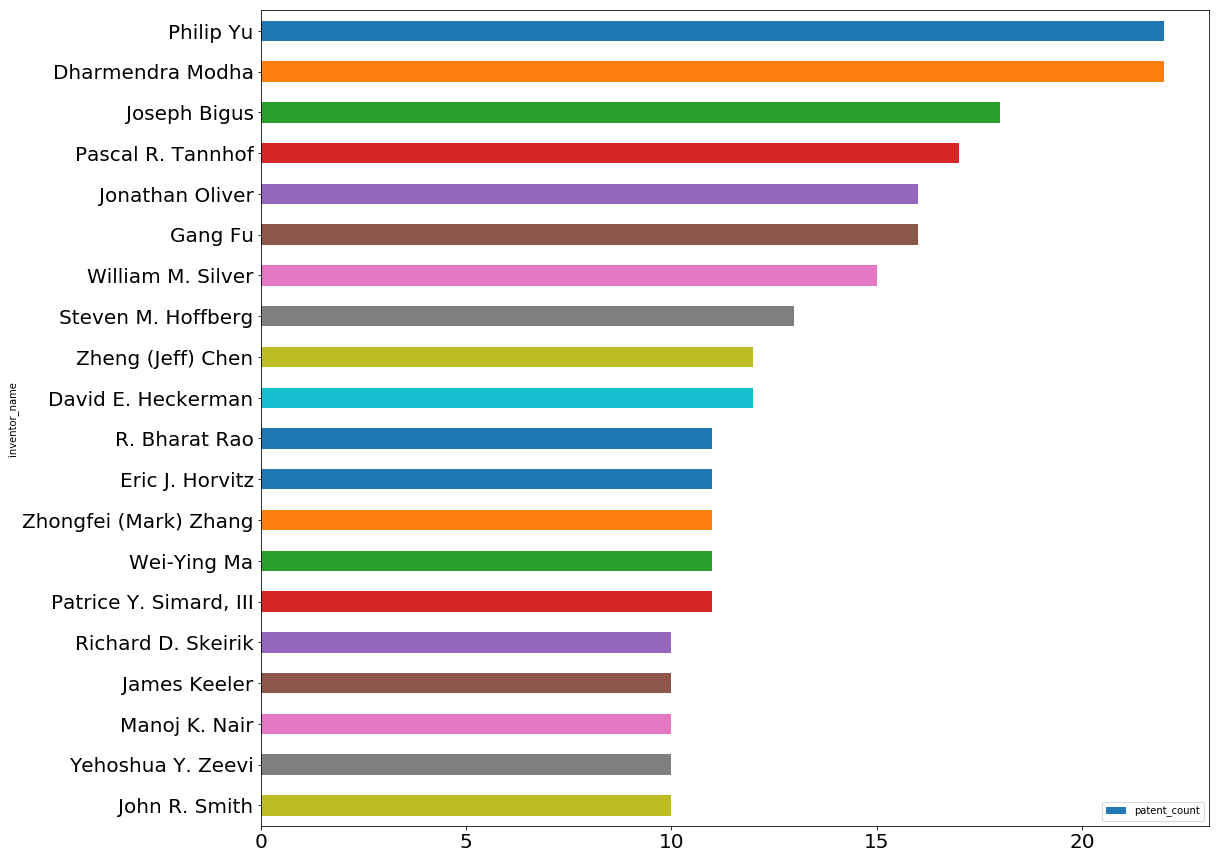

In [258]:
all_ai_patents_copy = all_ai_patents.copy()
all_ai_patents_copy = all_ai_patents_copy[["patent_title","inventor_id"]]\
                      .rename(columns={'patent_title': 'patent_count',})
all_ai_patents_copy["patent_count"] = 1
top_inventors = all_ai_patents_copy.groupby(['inventor_id'])\
                .sum()\
                .sort_values(by='patent_count', ascending=False)
        
top_inventors["inventor_name"] = top_inventors.index
top_inventors["inventor_name"] = top_inventors["inventor_name"].apply(lambda row: inventor_id_name[row])

top_inventors.head(20).plot.barh(x='inventor_name', y='patent_count', figsize=(17,15), fontsize=20).invert_yaxis()

There is not much to interpret about this table (since we are already analyzing related companies and countries in other parts of the study) but here are some information about top 2 AI patent holders which confirm that we are on the right track.

**Philip Yu** is an American computer scientist and Professor in Information Technology at the University of Illinois at Chicago, known for his work in the field of data mining.

**Dharmendra Modha** is an Indian American manager and lead researcher of the Cognitive Computing group at IBM Almaden Research Center. He is known for his pioneering works in Artificial Intelligence and Mind Simulation.

**6.** Which companies are holding most AI patents? Is there a relationship between number of AI patents hold and the rank (according to Forbes top 500) of a company (meaning that smartest companies are also the the biggest ones)? 


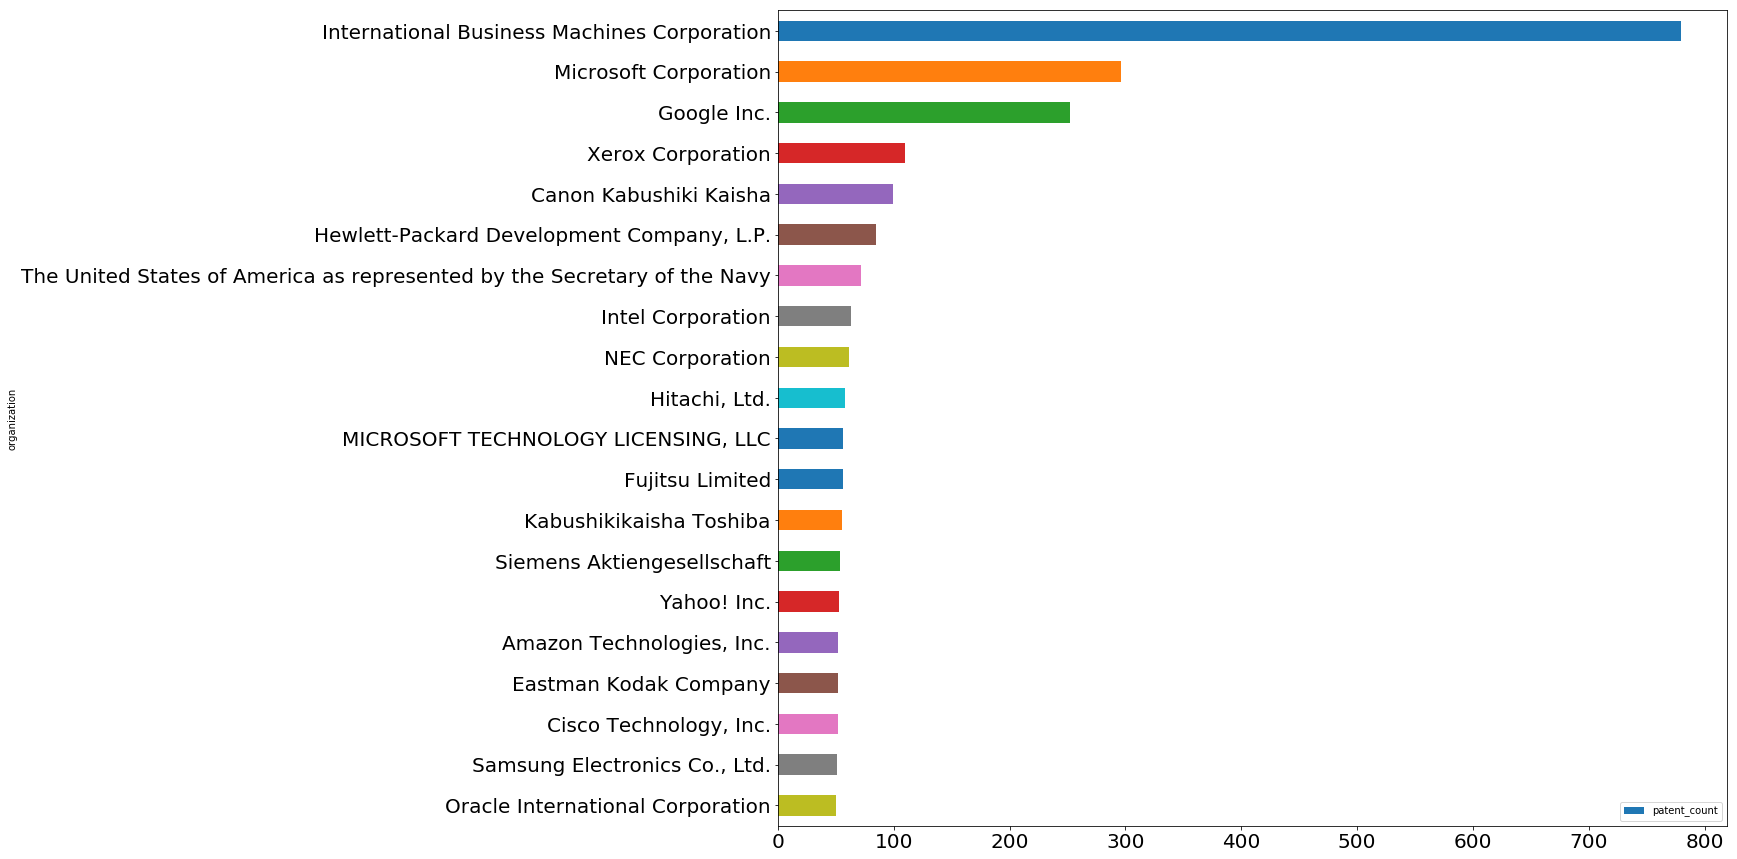

In [207]:
all_ai_patents_copy = all_ai_patents.copy()
all_ai_patents_copy = all_ai_patents_copy[["patent_title","organization"]]\
                      .rename(columns={'patent_title': 'patent_count',})
all_ai_patents_copy["patent_count"] = 1
top_organizations = all_ai_patents_copy.groupby(['organization'])\
                .sum()\
                .sort_values(by='patent_count', ascending=False)
        
top_organizations["organization"] = top_organizations.index
top_organizations.head(20).plot.barh(x='organization', y='patent_count', figsize=(17,15), fontsize=20).invert_yaxis()

**[Interpretation of the Figure]**

To be able to compare ranks we found (based on number of AI patents) and Forbes global 500 list, we first scrap the top 500 list from Forbes.

In [239]:
pickle_in = open("data/company_ranks.pickle","rb")
company_ranks = pickle.load(pickle_in)

COMPARE W/ FORBES

In [257]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    display(top_organizations.head(100))

,patent_count,organization
organization,,
International Business Machines Corporation,780,International Business Machines Corporation
Microsoft Corporation,296,Microsoft Corporation
Google Inc.,252,Google Inc.
Xerox Corporation,110,Xerox Corporation
Canon Kabushiki Kaisha,99,Canon Kabushiki Kaisha
"Hewlett-Packard Development Company, L.P.",85,"Hewlett-Packard Development Company, L.P."
The United States of America as represented by the Secretary of the Navy,72,The United States of America as represented by...
Intel Corporation,63,Intel Corporation
NEC Corporation,61,NEC Corporation


In [232]:
comapny_rankscomapny_ranks

{'3M': 196,
 'ABB': 235,
 'AIA Group': 110,
 'AIRBUS': 165,
 'ANZ': 91,
 'AT&amp;T': 10,
 'AXA Group': 26,
 'AbbVie': 142,
 'Abbott Laboratories': 241,
 'Accenture': 271,
 'Adidas': 467,
 'Aegon': 483,
 'Aetn': 159,
 'Aflac': 198,
 'Agricultural Bank of Chin': 5,
 'Air Liquide': 253,
 'Aisin Seiki': 476,
 'Alibab': 139,
 'Allergan': 148,
 'Allianz': 20,
 'Allstate': 199,
 'Alphabet': 23,
 'Altria Group': 176,
 'Amazon.com': 82,
 'American Airlines Group': 246,
 'American Electric': 394,
 'American Express': 96,
 'American International Group': 402,
 'Ameriprise Financial': 342,
 'AmerisourceBergen': 314,
 'Amgen': 130,
 'América Móvil': 339,
 'Anglo American': 327,
 'Anheuser-Busch InBev': 125,
 'Anthem': 154,
 'Aon': 443,
 'Apple': 8,
 'Applied Materials': 498,
 'ArcelorMittal': 215,
 'Archer Daniels Midland': 290,
 'AstraZenec': 175,
 'Automatic Data Processing': 333,
 'Aviv': 207,
 'Axis Bank': 462,
 'BAE Systems': 364,
 'BASF': 92,
 'BB&amp;T': 247,
 'BBVA-Banco Bilbao Vizcay': 104

--

**7.** Considering that Putin recently said “the nation that leads in AI will be the ruler of the world”. What is the relationship between number AI related patents and the rank of countries’ defense industry?